In [ ]:
# # Imports and Logger
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import awswrangler as wr
# from statsmodels.tsa.stattools import adfuller
# from scipy import stats
# import logging
# from IPython.display import display
# from sklearn.decomposition import PCA
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler

# # Configure logger
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger(__name__)


# # ADF Test Function - To test stationarity of timeseries
# def perform_adf_test(series, title):
#     series = series.dropna()
#     result = adfuller(series)
#     return {
#             'title': title,
#             'adf_statistic': result[0],
#             'p_value': result[1],
#             'critical_values': result[4],
#             'is_stationary': result[1] < 0.05
#         }


# # Rolling Statistics Plot
# def plot_rolling_statistics(series, title, window=30):
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.plot(series, label='Original', color='#766CDB')
#     ax.plot(series.rolling(window).mean(), label=f'Rolling Mean ({window})', color='#DA847C')
#     ax.plot(series.rolling(window).std(), label=f'Rolling Std ({window})', color='#D9CC8B')
#     ax.set_title(f'Rolling Statistics: {title}', fontsize=20)
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Value')
#     ax.legend()
#     ax.grid(True)
#     plt.tight_layout()
#     plt.show()


# # Histogram Plot
# def plot_histogram(series, title):
#     fig, ax = plt.subplots(figsize=(9, 6))
#     sns.histplot(series, kde=True, ax=ax, color='#766CDB')
#     x = np.linspace(series.min(), series.max(), 100)
#     mean, std = series.mean(), series.std()
#     pdf = stats.norm.pdf(x, mean, std)
#     scaled_pdf = pdf * (len(series) * (series.max() - series.min()) / 10)
#     ax.plot(x, scaled_pdf, color='#DA847C', label='Normal Distribution')
#     ax.set_title(f'Distribution: {title}', fontsize=20)
#     ax.set_xlabel('Value')
#     ax.set_ylabel('Frequency')
#     ax.legend()
#     ax.grid(True)
#     plt.tight_layout()
#     plt.show()


# #  Run ADF tests and visuals
# def run_stationarity_analysis(df, columns):
#     results = []
#     for column in columns:
#         logger.info(f"Analyzing stationarity for {column}...")
#         series = df[column]
#         result = perform_adf_test(series, column)
#         results.append(result)
#         logger.info(f"ADF Statistic: {result['adf_statistic']:.4f}, p-value: {result['p_value']:.4f}, Stationary: {result['is_stationary']}")
#         plot_rolling_statistics(series, column)
#         plot_histogram(series, column)
#     return pd.DataFrame({
#             'Series': [r['title'] for r in results],
#             'ADF Statistic': [r['adf_statistic'] for r in results],
#             'p-value': [r['p_value'] for r in results],
#             'Is Stationary': [r['is_stationary'] for r in results]
#         })


# # Feature Engineering
# def create_domain_features(df):
#     logger.info("Creating new feature: high_energy")
#     df['high_energy'] = np.where(df['energy_output_btu'] > df['energy_output_btu'].quantile(0.75), 1, 0)

#     logger.info("Creating new feature: energy_flow_ratio")
#     if 'flow_rate' in df.columns:
#         df['energy_flow_ratio'] = df['energy_output_btu'] / df['flow_rate'].replace(0, np.nan)
#         df['energy_flow_ratio'] = df['energy_flow_ratio'].fillna(0)
#     else:
#         df['energy_flow_ratio'] = np.nan

#     logger.info("Creating new feature: temp_diff")
#     if 'vl_comp_oilcooleroutlet_temp' in df.columns and 'vl_comp_oilinjection_temp' in df.columns:
#         df['temp_diff'] = df['vl_comp_oilcooleroutlet_temp'] - df['vl_comp_oilinjection_temp']
#     else:
#         df['temp_diff'] = np.nan

#     logger.info("Feature engineering complete.")
#     return df


# def main():

#     # Orchestration
#     s3_input = 's3://sagemaker-us-east-2-426179662034/canvas/processed/facilities_cleaned.csv'
#     s3_output = 's3://sagemaker-us-east-2-426179662034/canvas/processed/facility_feature_engineered.csv'

#     logger.info(f"Reading dataset from: {s3_input}")
#     df = wr.s3.read_csv(s3_input)

#     # Run stationarity tests
#     columns_to_test = [
#         'energy_output_btu', 'methane_percent', 'bge_h2soutlet_temp',
#         'abb_gc_outletstream_pressure', 'bge_accumruntime', 'vl_comp_suction_temp',
#         'vl_comp_suction_pressure', 'bge_blowersuction_temp', 'bge_blowersuction_pressure',
#         'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2'
#     ]
#     adf_summary = run_stationarity_analysis(df, columns_to_test)
#     display(adf_summary)

#     # Create features
#     df = create_domain_features(df)

#     # Add lag features
#     lag_columns = [
#         'bge_h2soutlet_temp', 'vl_comp_suction_temp', 'vl_comp_suction_pressure',
#         'bge_blowersuction_temp', 'bge_blowersuction_pressure',
#         'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2'
#     ]
#     for col in lag_columns:
#         if col in df.columns:
#             for lag in range(1, 4):
#                 df[f'{col}_lag{lag}'] = df[col].shift(lag)

#     logger.info(f"Lag features (1-3) added for {len(lag_columns)} variables.")

#     # One-hot encode facility and site_comm_date
#     if 'facility' in df.columns:
#         df = pd.get_dummies(df, columns=['facility'], prefix='facility')
#         logger.info("One-hot encoding applied to 'facility'")

#     if 'site_comm_date' in df.columns:
#         df = pd.get_dummies(df, columns=['site_comm_date'], prefix='site_comm_date')
#         logger.info("One-hot encoding applied to 'site_comm_date'")

#     # Add rolling window features
#     rolling_targets = [
#         'bge_h2soutlet_temp', 'vl_comp_suction_temp', 'vl_comp_suction_pressure',
#         'bge_blowersuction_temp', 'bge_blowersuction_pressure',
#         'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2',
#         'energy_output_btu', 'methane_percent'
#     ]
#     for col in rolling_targets:
#         if col in df.columns:
#             df[f'{col}_rollmean_3'] = df[col].rolling(window=3).mean()
#             df[f'{col}_rollstd_3'] = df[col].rolling(window=3).std()
#             df[f'{col}_rollmean_7'] = df[col].rolling(window=7).mean()
#             df[f'{col}_rollstd_7'] = df[col].rolling(window=7).std()

#     logger.info(f"Rolling window features (mean/std) added for {len(rolling_targets)} variables.")

#     # Add PCA features
#     numeric_df = df.select_dtypes(include=[np.number]).dropna()
#     scaled_data = StandardScaler().fit_transform(numeric_df)
#     pca_components = PCA(n_components=12).fit_transform(scaled_data)
#     df_pca = pd.DataFrame(pca_components, columns=[f'PC_{i+1}' for i in range(12)])
#     df = df.reset_index(drop=True).join(df_pca)
#     logger.info("Top 12 PCA components added to dataset.")

#     # 2D PCA Visualization
#     pca_2d = PCA(n_components=2)
#     pca_2d_result = pca_2d.fit_transform(scaled_data)

#     plt.figure(figsize=(10, 7))
#     plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], alpha=0.6, s=30, c="#7CD9A5")
#     plt.title("2D PCA Projection of Feature Space", fontsize=16)
#     plt.xlabel("Principal Component 1")
#     plt.ylabel("Principal Component 2")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Feature importance using RandomForest
#     engineered_cols = [col for col in df.columns if any(keyword in col for keyword in ["lag", "roll", "PC_"])]

#     if 'high_energy' in df.columns:
#         y = df['high_energy']
#     else:
#         y = np.random.randint(0, 2, size=len(df))  # fallback dummy target

#     X = df[engineered_cols]
#     X = SimpleImputer(strategy='mean').fit_transform(X)

#     rf = RandomForestClassifier(n_estimators=100, random_state=42)
#     rf.fit(X, y)

#     importances = rf.feature_importances_
#     feature_ranks = pd.Series(importances, index=engineered_cols).sort_values(ascending=False)

#     plt.figure(figsize=(12, 6))
#     feature_ranks.head(20).plot(kind='barh', color='#766CDB')
#     plt.title("Top 20 Engineered Features by Importance")
#     plt.xlabel("Feature Importance Score")
#     plt.gca().invert_yaxis()
#     plt.tight_layout()
#     plt.show()

#     logger.info("Engineered feature importance ranking complete.")

#     # Write back to S3
#     wr.s3.to_csv(df, path=s3_output, index=False)
#     logger.info(f"Feature-engineered dataset written to: {s3_output}")


# # Only run if script is executed directly
# if __name__ == "__main__":
#     main()

2025-04-10 00:28:27,391 - INFO - Reading dataset from: s3://sagemaker-us-east-2-426179662034/canvas/processed/facilities_cleaned_sample.csv
2025-04-10 00:28:27,470 - INFO - Initializing a Ray instance
2025-04-10 00:28:28,891	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 904900608 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.01gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-04-10 00:28:29,978	INFO worker.py:1786 -- Started a local Ray instance.
2025-04-10 00:28:32,143 - INFO - Analyzing stationarity for energy_output_btu...
2025-04-10 00:28:32,213 - INFO - Analyzing stationarity for methane_percent...
2025-04-10 00:28:32,283 - INFO - Analyzing stationarity for bge_h2soutl

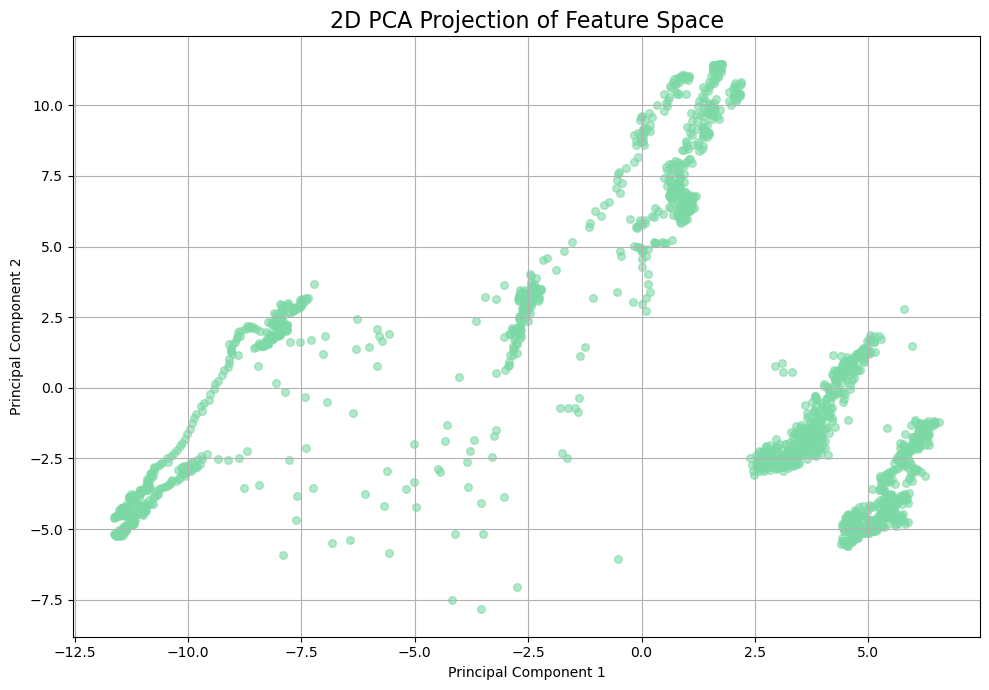

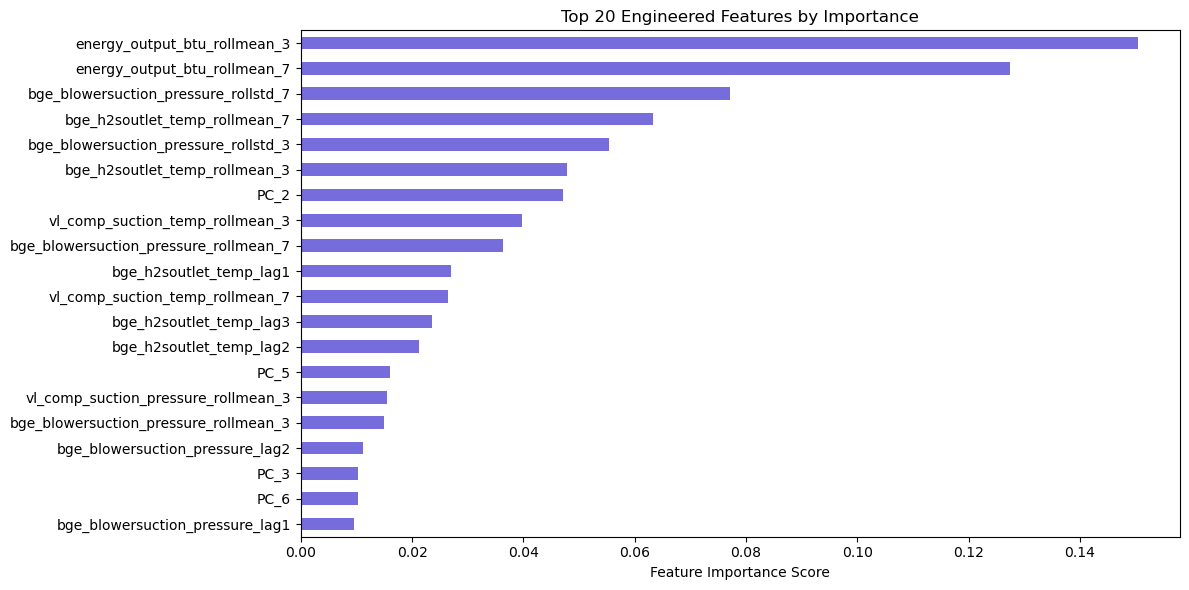

2025-04-10 00:28:34,417 - INFO - Top 10 features:
energy_output_btu_rollmean_3             0.150442
energy_output_btu_rollmean_7             0.127448
bge_blowersuction_pressure_rollstd_7     0.077059
bge_h2soutlet_temp_rollmean_7            0.063281
bge_blowersuction_pressure_rollstd_3     0.055326
bge_h2soutlet_temp_rollmean_3            0.047773
PC_2                                     0.047073
vl_comp_suction_temp_rollmean_3          0.039787
bge_blowersuction_pressure_rollmean_7    0.036272
bge_h2soutlet_temp_lag1                  0.026935
2025-04-10 00:28:35,002 - INFO - Feature-engineered dataset written to: s3://sagemaker-us-east-2-426179662034/canvas/processed/facility_feature_engineered.csv
*** SIGTERM received at time=1744244985 on cpu 0 ***
PC: @     0x7f397d593e2e  (unknown)  epoll_wait
    @     0x7f391ea8f4fd         64  absl::lts_20230802::AbslFailureSignalHandler()
    @     0x7f397d4b0520  (unknown)  (unknown)
[2025-04-10 00:29:45,526 E 22897 22897] logging.cc:440: ***

In [1]:
# Imports and Logger
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend to save memory in headless environments
import matplotlib.pyplot as plt
import seaborn as sns
import awswrangler as wr
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import logging
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Configure logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# ADF Test Function - To test stationarity of timeseries
def perform_adf_test(series, title):
    series = series.dropna()
    result = adfuller(series)
    return {
        'title': title,
        'adf_statistic': result[0],
        'p_value': result[1],
        'critical_values': result[4],
        'is_stationary': result[1] < 0.05
    }


#  Run ADF tests and visuals
def run_stationarity_analysis(df, columns):
    results = []
    for column in columns:
        logger.info(f"Analyzing stationarity for {column}...")
        series = df[column]
        result = perform_adf_test(series, column)
        results.append(result)
    return pd.DataFrame({
        'Series': [r['title'] for r in results],
        'ADF Statistic': [r['adf_statistic'] for r in results],
        'p-value': [r['p_value'] for r in results],
        'Is Stationary': [r['is_stationary'] for r in results]
    })


# Feature Engineering
def create_domain_features(df):
    logger.info("Creating new feature: high_energy")
    df['high_energy'] = np.where(df['energy_output_btu'] > df['energy_output_btu'].quantile(0.75), 1, 0)

    logger.info("Creating new feature: energy_flow_ratio")
    if 'flow_rate' in df.columns:
        df['energy_flow_ratio'] = df['energy_output_btu'] / df['flow_rate'].replace(0, np.nan)
        df['energy_flow_ratio'] = df['energy_flow_ratio'].fillna(0)
    else:
        df['energy_flow_ratio'] = np.nan

    logger.info("Creating new feature: temp_diff")
    if 'vl_comp_oilcooleroutlet_temp' in df.columns and 'vl_comp_oilinjection_temp' in df.columns:
        df['temp_diff'] = df['vl_comp_oilcooleroutlet_temp'] - df['vl_comp_oilinjection_temp']
    else:
        df['temp_diff'] = np.nan

    return df


def main():
    # Orchestration
    s3_input = 's3://sagemaker-us-east-2-426179662034/canvas/processed/facilities_cleaned_sample.csv'
    s3_output = 's3://sagemaker-us-east-2-426179662034/canvas/processed/facility_feature_engineered.csv'

    logger.info(f"Reading dataset from: {s3_input}")
    df = wr.s3.read_csv(s3_input)
    # print("^%"*30)
    # print(df.head(5))

    # # Drop columns with high null count, excluding essential features
    # columns_to_keep = set([
    #     'energy_output_btu', 'methane_percent', 'bge_h2soutlet_temp',
    #     'abb_gc_outletstream_pressure', 'bge_accumruntime', 'vl_comp_suction_temp',
    #     'vl_comp_suction_pressure', 'bge_blowersuction_temp', 'bge_blowersuction_pressure',
    #     'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2',
    #     'flow_rate', 'vl_comp_oilcooleroutlet_temp', 'vl_comp_oilinjection_temp'
    # ])

    # print("#^%"*30)
    # print(columns_to_keep)
    rolling_targets = [
        'bge_h2soutlet_temp', 'vl_comp_suction_temp', 'vl_comp_suction_pressure',
        'bge_blowersuction_temp', 'bge_blowersuction_pressure',
        'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2',
        'energy_output_btu', 'methane_percent'
    ]
    lag_columns = [
        'bge_h2soutlet_temp', 'vl_comp_suction_temp', 'vl_comp_suction_pressure',
        'bge_blowersuction_temp', 'bge_blowersuction_pressure',
        'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2'
    ]
    # required_columns = columns_to_keep.union(set(rolling_targets)).union(set(lag_columns))

    # print("$^%"*30)
    # print(required_columns)

    # null_thresh = 0.4 * len(df)
    # cols_to_drop = [col for col in df.columns if df[col].isnull().sum() > null_thresh and col not in required_columns]

    # if cols_to_drop:
    #     logger.info(f"Dropping {len(cols_to_drop)} columns with excessive nulls: {cols_to_drop}")
    #     df.drop(columns=cols_to_drop, inplace=True)

    # Run stationarity tests
    columns_to_test = [
        'energy_output_btu', 'methane_percent', 'bge_h2soutlet_temp',
        'abb_gc_outletstream_pressure', 'bge_accumruntime', 'vl_comp_suction_temp',
        'vl_comp_suction_pressure', 'bge_blowersuction_temp', 'bge_blowersuction_pressure',
        'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2'
    ]
    adf_summary = run_stationarity_analysis(df, columns_to_test)
    logger.info("ADF Summary:\n" + adf_summary.to_string())

    # Create features
    df = create_domain_features(df)

    # Add lag features
    for col in lag_columns:
        if col in df.columns:
            for lag in range(1, 4):
                df[f'{col}_lag{lag}'] = df[col].shift(lag)

    # One-hot encode facility and site_comm_date
    if 'facility' in df.columns:
        df = pd.get_dummies(df, columns=['facility'], prefix='facility')
    if 'site_comm_date' in df.columns:
        df = pd.get_dummies(df, columns=['site_comm_date'], prefix='site_comm_date')

    # Add rolling window features
    for col in rolling_targets:
        if col in df.columns:
            df[f'{col}_rollmean_3'] = df[col].rolling(window=3).mean()
            df[f'{col}_rollstd_3'] = df[col].rolling(window=3).std()
            df[f'{col}_rollmean_7'] = df[col].rolling(window=7).mean()
            df[f'{col}_rollstd_7'] = df[col].rolling(window=7).std()

    # Add PCA features
    numeric_df = df.select_dtypes(include=[np.number]).dropna()
    scaled_data = StandardScaler().fit_transform(numeric_df)
    pca_components = PCA(n_components=12).fit_transform(scaled_data)
    df_pca = pd.DataFrame(pca_components, columns=[f'PC_{i+1}' for i in range(12)])
    df = df.reset_index(drop=True).join(df_pca)

    # 2D PCA Visualization
    pca_2d = PCA(n_components=2)
    pca_2d_result = pca_2d.fit_transform(scaled_data)

    plt.figure(figsize=(10, 7))
    plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], alpha=0.6, s=30, c="#7CD9A5")
    plt.title("2D PCA Projection of Feature Space", fontsize=16)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    engineered_cols = [col for col in df.columns if any(keyword in col for keyword in ["lag", "roll", "PC_"])]
    y = df['high_energy'] if 'high_energy' in df.columns else np.random.randint(0, 2, size=len(df))
    X = df[engineered_cols]
    X = SimpleImputer(strategy='mean').fit_transform(X)

    # Feature importance using RandomForest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    feature_ranks = pd.Series(importances, index=engineered_cols).sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    feature_ranks.head(20).plot(kind='barh', color='#766CDB')
    plt.title("Top 20 Engineered Features by Importance")
    plt.xlabel("Feature Importance Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    logger.info("Top 10 features:\n" + feature_ranks.head(10).to_string())

    wr.s3.to_csv(df, path=s3_output, index=False)
    logger.info(f"Feature-engineered dataset written to: {s3_output}")


if __name__ == "__main__":
    main()
